# CRF Model Training
Based on Henning and Alshomary's work, in this notebook we split and train the modified dataset

In [2]:
%load_ext autoreload

In [3]:
%pip install pytorch-crf

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import sys
import os

sys.path.insert(0, './lib/src')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # for debugging

In [1]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.nn import functional as F
from transformers import BertConfig, BertTokenizer, get_polynomial_decay_schedule_with_warmup
from itertools import chain

import torch
import random
import os, sys
import numpy as np
import argparse
import time
import json
import pandas as pd

from glob import glob
from sklearn.model_selection import train_test_split

In [7]:
%autoreload
from multi_turn_bert import MultiTurnBert
from custom_dataset import CustomDataset, process_df
from main import *

In [8]:
import torch 
import random
torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)
random.seed(123)

In [9]:
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [10]:
mace_annotation_df = pd.read_pickle('./data_turns.pkl')

In [11]:
mace_annotation_df['turn_len'] = mace_annotation_df.turn_text.apply(lambda x: len(x['text'].split()))

<AxesSubplot:>

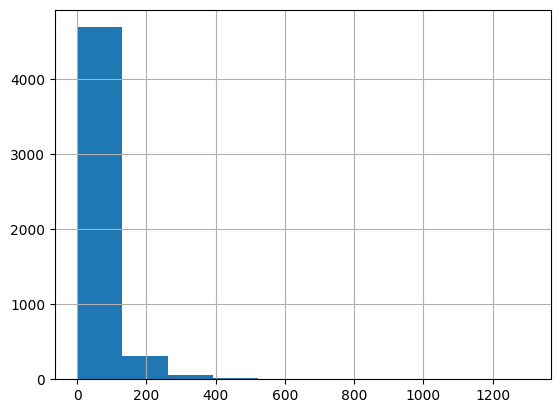

In [12]:
mace_annotation_df.turn_len.hist()

In [13]:
mace_annotation_df['turn_text'] = mace_annotation_df.apply(lambda row: {
                                            'author': row['turn_text']['author'], 
                                            'text' : row['topic'].replace('_', ' ') + ' [SEP] ' +  row['turn_text']['text']
                                           } ,axis=1)

In [14]:
mace_annotation_df = mace_annotation_df.groupby('task_id').agg({'turn_text': lambda rows: list(rows),
                                                                'topic': lambda rows: list(rows)[0],
                                                               'topic_func_label': lambda rows: list(rows),
                                                               'dlg_act_label': lambda rows: list(rows),
                                                               'exp_act_label': lambda rows: list(rows)}).reset_index()

In [15]:
mace_annotation_df['num_turns_per_topic'] = mace_annotation_df.topic_func_label.apply(lambda x : len(x))

<AxesSubplot:>

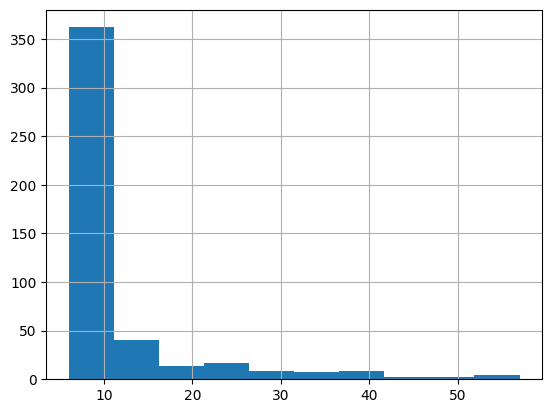

In [16]:
mace_annotation_df.num_turns_per_topic.hist()

In [17]:
mace_annotation_df.num_turns_per_topic.max()

57

In [18]:
parser = argparse.ArgumentParser()
args = argparse.Namespace(turn_type='multi', pooling='cls', sp1_token='[EXPLAINER]', sp2_token='[EXPLAINEE]', bert_type='bert-base-uncased',
                          max_len=256, max_turns=56, dropout=0.1, device='cuda', learning_rate=2e-5, warmup_ratio=0.01,
                          batch_size=1, num_workers=2, num_epochs=5, num_classes=-1, ckpt_dir='./cross-val-models', planning=True, start_token='[START]')

### Train to predict explanation act:

In [18]:
args.ckpt_dir='./exp_act_models'
args.num_classes=10

In [19]:
label_clm = 'exp_act_label'
mace_annotation_df['label'] = mace_annotation_df[label_clm].apply(lambda labels: [int(x[2:4])-1 for x in labels]) #making labels parasable as integers

In [20]:
'''
topics = mace_annotation_df.topic.unique()
train_topics, valid_topics, test_topics = topics[:9], topics[9:11], topics[11:] 


training_df = mace_annotation_df[mace_annotation_df.topic.isin(train_topics)].copy()
valid_df = mace_annotation_df[mace_annotation_df.topic.isin(valid_topics)].copy()
test_df = mace_annotation_df[mace_annotation_df.topic.isin(test_topics)].copy()'''

train, validate, test = \
              np.split(mace_annotation_df.sample(frac=1, random_state=42), 
                       [int(.6*len(mace_annotation_df)), int(.8*len(mace_annotation_df))])


training_df = train.copy()
valid_df = validate.copy()
test_df = test.copy()

In [21]:
model, eval_results = run_experiment(args, training_df, valid_df, test_df)

278it [00:02, 97.25it/s] 
100%|██████████| 278/278 [00:00<00:00, 3550.38it/s]


2992 samples are prepared


93it [00:00, 106.56it/s]
100%|██████████| 93/93 [00:00<00:00, 3756.38it/s]


1063 samples are prepared


93it [00:00, 111.07it/s]
100%|██████████| 93/93 [00:00<00:00, 4166.71it/s]


1017 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 2992/2992 [31:02<00:00,  1.61it/s]


Train loss: 4.201074439773266 || Train accuracy: 0.8441873696188128 || Train F1 score: 0.7937157817461672
Validation processing...


100%|██████████| 1063/1063 [03:41<00:00,  4.80it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.40422568081448207
Validation loss: 14.364411083124542 || Validation accuracy: 0.6861300251842178 || Current validation F1 score: 0.40422568081448207
################################################## Epoch: 2 ##################################################


100%|██████████| 2992/2992 [31:00<00:00,  1.61it/s]


Train loss: 1.895338973418914 || Train accuracy: 0.9212592452114545 || Train F1 score: 0.9186525523431698
Validation processing...


100%|██████████| 1063/1063 [03:41<00:00,  4.80it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4223635519825071
Validation loss: 15.207017419479529 || Validation accuracy: 0.6907004943568696 || Current validation F1 score: 0.4223635519825071
################################################## Epoch: 3 ##################################################


100%|██████████| 2992/2992 [30:59<00:00,  1.61it/s]


Train loss: 1.6978453168257035 || Train accuracy: 0.9253935141285795 || Train F1 score: 0.925593742053944
Validation processing...


100%|██████████| 1063/1063 [03:41<00:00,  4.80it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.4239728898067435
Validation loss: 16.94753417896978 || Validation accuracy: 0.6885551720921556 || Current validation F1 score: 0.4239728898067435
################################################## Epoch: 4 ##################################################


100%|██████████| 2992/2992 [30:59<00:00,  1.61it/s]


Train loss: 1.6310867569982048 || Train accuracy: 0.9250521524748719 || Train F1 score: 0.9255799265985036
Validation processing...


100%|██████████| 1063/1063 [03:41<00:00,  4.80it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.4239728898067435
Validation loss: 17.181477290105953 || Validation accuracy: 0.6888349967353792 || Current validation F1 score: 0.4098611546647583
################################################## Epoch: 5 ##################################################


100%|██████████| 2992/2992 [31:00<00:00,  1.61it/s]


Train loss: 1.5949188982420426 || Train accuracy: 0.9267589607434098 || Train F1 score: 0.9274729641903494
Validation processing...


100%|██████████| 1063/1063 [03:41<00:00,  4.80it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.4239728898067435
Validation loss: 17.32707211484577 || Validation accuracy: 0.6920996175729875 || Current validation F1 score: 0.4100057129033113
Training finished!
Testing the model...


100%|██████████| 1017/1017 [03:31<00:00,  4.80it/s]

<Test Result>
Test accuracy: 0.6414563197898095 || Test F1 score: 0.4131984535494772
GOOD BYE.


In [22]:
args.planning = False #with last turntext

In [23]:
model, eval_results = run_experiment(args, training_df, valid_df, test_df)

278it [00:02, 97.39it/s] 
100%|██████████| 278/278 [00:00<00:00, 3829.72it/s]


2992 samples are prepared


93it [00:00, 107.81it/s]
100%|██████████| 93/93 [00:00<00:00, 4271.37it/s]


1063 samples are prepared


93it [00:00, 109.49it/s]
100%|██████████| 93/93 [00:00<00:00, 3608.25it/s]


1017 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 2992/2992 [31:00<00:00,  1.61it/s]


Train loss: 3.092118809766629 || Train accuracy: 0.8938365256969467 || Train F1 score: 0.8252742970845108
Validation processing...


100%|██████████| 1063/1063 [03:41<00:00,  4.80it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.41403814587339316
Validation loss: 14.677751857384353 || Validation accuracy: 0.6996548829400242 || Current validation F1 score: 0.41403814587339316
################################################## Epoch: 2 ##################################################


100%|██████████| 2992/2992 [31:00<00:00,  1.61it/s]


Train loss: 0.5552101278687543 || Train accuracy: 0.979290726341741 || Train F1 score: 0.9662693613010905
Validation processing...


100%|██████████| 1063/1063 [03:41<00:00,  4.80it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.41403814587339316
Validation loss: 17.438216128667793 || Validation accuracy: 0.7102882193825203 || Current validation F1 score: 0.39232216201507136
################################################## Epoch: 3 ##################################################


100%|██████████| 2992/2992 [31:00<00:00,  1.61it/s]


Train loss: 0.3462157667001938 || Train accuracy: 0.9829698463872558 || Train F1 score: 0.9721491283128076
Validation processing...


100%|██████████| 1063/1063 [03:41<00:00,  4.80it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.41403814587339316
Validation loss: 18.69537065708738 || Validation accuracy: 0.6966700867456393 || Current validation F1 score: 0.3905215556173697
################################################## Epoch: 4 ##################################################


100%|██████████| 2992/2992 [31:00<00:00,  1.61it/s]


Train loss: 0.26248399204111356 || Train accuracy: 0.9857765977621847 || Train F1 score: 0.9777127342503634
Validation processing...


100%|██████████| 1063/1063 [03:41<00:00,  4.80it/s]


The f1 score did not improve by 0.0001. Patience: 3
Best validtion f1 score: 0.41403814587339316
Validation loss: 19.61859427817229 || Validation accuracy: 0.7076765227124335 || Current validation F1 score: 0.4067474961513088
Run out of patience. Abort!
Training finished!
Testing the model...


100%|██████████| 1017/1017 [03:31<00:00,  4.80it/s]

<Test Result>
Test accuracy: 0.6656657595946326 || Test F1 score: 0.4183432487904611
GOOD BYE.


### Train to predict topic relation:

In [19]:
args.ckpt_dir='./topic_rel_models'
args.num_classes=4
args.planning = True #without last turntext

In [20]:
label_clm = 'topic_func_label'

In [21]:
mace_annotation_df['label'] = mace_annotation_df[label_clm].apply(lambda labels: [int(x[2:4])-1 for x in labels]) #making labels parasable as integers

In [22]:
#split data
train, validate, test = \
              np.split(mace_annotation_df.sample(frac=1, random_state=42), 
                       [int(.6*len(mace_annotation_df)), int(.8*len(mace_annotation_df))])

training_df = train.copy()
valid_df = validate.copy()
test_df = test.copy()

In [23]:
model, eval_results = run_experiment(args, training_df, valid_df, test_df)

278it [00:02, 96.83it/s] 
100%|██████████| 278/278 [00:00<00:00, 3854.31it/s]


2992 samples are prepared


93it [00:00, 106.10it/s]
100%|██████████| 93/93 [00:00<00:00, 4635.80it/s]


1063 samples are prepared


93it [00:00, 108.81it/s]
100%|██████████| 93/93 [00:00<00:00, 4560.04it/s]


1017 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 2992/2992 [31:01<00:00,  1.61it/s]


Train loss: 4.346651713976407 || Train accuracy: 0.7987483406030722 || Train F1 score: 0.7631546833012329
Validation processing...


100%|██████████| 1063/1063 [03:42<00:00,  4.78it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.52835013569436
Validation loss: 11.388003509221836 || Validation accuracy: 0.6558156888349967 || Current validation F1 score: 0.52835013569436
################################################## Epoch: 2 ##################################################


100%|██████████| 2992/2992 [31:01<00:00,  1.61it/s]


Train loss: 1.7944279003509864 || Train accuracy: 0.9088564384600797 || Train F1 score: 0.9012572477598427
Validation processing...


100%|██████████| 1063/1063 [03:42<00:00,  4.78it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.52835013569436
Validation loss: 15.286824317889065 || Validation accuracy: 0.6789478593414794 || Current validation F1 score: 0.5161533593088387
################################################## Epoch: 3 ##################################################


100%|██████████| 2992/2992 [30:59<00:00,  1.61it/s]


Train loss: 1.531709136650524 || Train accuracy: 0.915683671534231 || Train F1 score: 0.9095210902142337
Validation processing...


100%|██████████| 1063/1063 [03:42<00:00,  4.78it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5331608207348589
Validation loss: 15.942889543265974 || Validation accuracy: 0.674284115287753 || Current validation F1 score: 0.5331608207348589
################################################## Epoch: 4 ##################################################


100%|██████████| 2992/2992 [31:04<00:00,  1.60it/s]


Train loss: 1.4435978403544043 || Train accuracy: 0.9199696567418927 || Train F1 score: 0.9124773989535794
Validation processing...


100%|██████████| 1063/1063 [03:42<00:00,  4.77it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5384621774042698
Validation loss: 16.471056015897446 || Validation accuracy: 0.6792276839847029 || Current validation F1 score: 0.5384621774042698
################################################## Epoch: 5 ##################################################


100%|██████████| 2992/2992 [31:05<00:00,  1.60it/s]


Train loss: 1.4036880640741338 || Train accuracy: 0.9220557557367722 || Train F1 score: 0.9152398084064669
Validation processing...


100%|██████████| 1063/1063 [03:42<00:00,  4.77it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.5384621774042698
Validation loss: 16.907363679873303 || Validation accuracy: 0.686503124708516 || Current validation F1 score: 0.5343566505266197
Training finished!
Testing the model...


100%|██████████| 1017/1017 [03:33<00:00,  4.76it/s]

<Test Result>
Test accuracy: 0.7044196302899502 || Test F1 score: 0.4874316778449117
GOOD BYE.


In [24]:
args.planning = False #with last turntext

In [25]:
model, eval_results = run_experiment(args, training_df, valid_df, test_df)

278it [00:02, 95.36it/s] 
100%|██████████| 278/278 [00:00<00:00, 4291.48it/s]


2992 samples are prepared


93it [00:00, 103.37it/s]
100%|██████████| 93/93 [00:00<00:00, 4872.95it/s]


1063 samples are prepared


93it [00:00, 107.05it/s]
100%|██████████| 93/93 [00:00<00:00, 4942.67it/s]


1017 samples are prepared


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training starts.
################################################## Epoch: 1 ##################################################


100%|██████████| 2992/2992 [31:06<00:00,  1.60it/s]


Train loss: 3.500700944526629 || Train accuracy: 0.848359567608572 || Train F1 score: 0.8155005843575303
Validation processing...


100%|██████████| 1063/1063 [03:42<00:00,  4.77it/s]


***** Current best checkpoint is saved. *****
Best validtion f1 score: 0.5814038231897228
Validation loss: 11.968816908148249 || Validation accuracy: 0.7167241861766627 || Current validation F1 score: 0.5814038231897228
################################################## Epoch: 2 ##################################################


100%|██████████| 2992/2992 [31:05<00:00,  1.60it/s]


Train loss: 0.6526829873654931 || Train accuracy: 0.9735634363739807 || Train F1 score: 0.9682678366567868
Validation processing...


100%|██████████| 1063/1063 [03:43<00:00,  4.76it/s]


The f1 score did not improve by 0.0001. Patience: 1
Best validtion f1 score: 0.5814038231897228
Validation loss: 14.534577129028479 || Validation accuracy: 0.718030034511706 || Current validation F1 score: 0.5715267714681335
################################################## Epoch: 3 ##################################################


100%|██████████| 2992/2992 [31:06<00:00,  1.60it/s]


Train loss: 0.391239325949215 || Train accuracy: 0.9788355774701308 || Train F1 score: 0.9745639534845381
Validation processing...


100%|██████████| 1063/1063 [03:41<00:00,  4.80it/s]


The f1 score did not improve by 0.0001. Patience: 2
Best validtion f1 score: 0.5814038231897228
Validation loss: 16.54347125001371 || Validation accuracy: 0.7062773994963156 || Current validation F1 score: 0.5441271626581674
################################################## Epoch: 4 ##################################################


100%|██████████| 2992/2992 [30:55<00:00,  1.61it/s]


Train loss: 0.299665552648631 || Train accuracy: 0.9811113218281813 || Train F1 score: 0.9775396170370795
Validation processing...


100%|██████████| 1063/1063 [03:41<00:00,  4.80it/s]


The f1 score did not improve by 0.0001. Patience: 3
Best validtion f1 score: 0.5814038231897228
Validation loss: 16.154839543946373 || Validation accuracy: 0.7145788639119485 || Current validation F1 score: 0.5728451087704125
Run out of patience. Abort!
Training finished!
Testing the model...


100%|██████████| 1017/1017 [03:31<00:00,  4.81it/s]

<Test Result>
Test accuracy: 0.7147414844703012 || Test F1 score: 0.5319877122734382
GOOD BYE.
